<a href="https://colab.research.google.com/github/Mahmood-Hussain/TransferLearningPyTorch/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook is an example how to use transfer learning on custom datasets. 

### Install Kaggle 

In [ ]:
! pip install -q kaggle

### Upload kaggle.json

Obtaining API Key (kaggle.json file) from kaggle steps

0. Go to kaggle.com create an account and verify mobile number 
1. Go to account section 
2. You will see API section click on create new api token a kaggle.json file will be downloaded 
3. Run cell below and upload that file here




In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mhbhat","key":"426b7fa94af609281b7af55cf914d3f5"}'}

make kaggle directory and download daaset of your choice

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d prasunroy/natural-images

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 341M/342M [00:11<00:00, 30.9MB/s]
100% 342M/342M [00:11<00:00, 31.9MB/s]


### unzip daaset quietly (-qq)

In [ ]:
!unzip -qq natural-images.zip

Import libraries

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader
import torchvision
from torchvision.models import vgg19
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

Prepare Dataset

In [ ]:
root_dir = './natural_images'
# hyperparameters
size = 224
batch_size = 64
lr = 0.01
epochs=5
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(size),
    transforms.ToTensor()
])

label_names = {
    0: 'airplane',
    1: 'car',
    2: 'cat',
    3: 'dog',
    4: 'flower',
    5: 'fruit',
    6: 'motorbike',
    7: 'person'
}

dataset = datasets.ImageFolder(root=root_dir, transform=transform)
test_size = int(len(dataset) * 0.2)
train_size = len(dataset) - test_size
test_ds, train_ds = random_split(dataset, lengths=[test_size, train_size])

train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Visualize image sample

cat


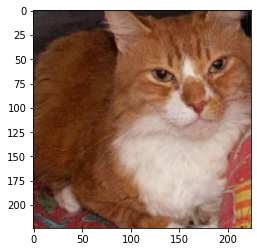

In [ ]:
images, labels = next(iter(train_loader))
print(label_names[labels[0].item()])
plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())


In [ ]:
vgg_feats = vgg19(weights='IMAGENET1K_V1').features
fake_img = torch.randn(1, 3, 244, 244)
out = vgg_feats(fake_img)
out.shape

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

torch.Size([1, 512, 7, 7])

In [ ]:
class NIModel(nn.Module):
  def __init__(self, in_channels=3, num_classes=8):
    super().__init__()
    self.vgg_feats = vgg19(weights='IMAGENET1K_V1').features
    self.fc1 = nn.Linear(in_features=512*7*7, out_features=2048)
    self.fc2 = nn.Linear(in_features=2048, out_features=8)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.vgg_feats(x)
    x = x.view(x.shape[0], -1)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    return x


Sometimes when you run some cells again CUDA gets out of memory this could be helpful in such situations

In [ ]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

70

Create a Model Instance, Optimizer and Loss function

In [ ]:
model = NIModel().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()


In [ ]:
# Testing loop
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0,0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")



In [ ]:
for epoch in range(epochs):
  running_corrects = 0
  running_loss = 0.0
  for idx, (images, class_indices) in enumerate(train_loader):
    images, class_indices = images.to(device), class_indices.to(device)
    # labels = nn.functional.one_hot(class_indices, num_classes=8)

    # zero grad
    optimizer.zero_grad()
    # forward
    output = model(images)

    # print(output)
    loss = criterion(output, class_indices) # compute the total loss
    loss.backward()  # compute updates for each paramete
    optimizer.step()  # make the updates for each parameter

    running_loss += loss.item()
    running_corrects += (output.argmax(1) == class_indices).type(torch.float).sum().item()

  running_loss /= len(train_loader)
  running_corrects /= len(train_loader.dataset)
  print(f'Epoch {epoch + 1}, Training Loss: {running_loss}, Training Accuracy: {(100*running_corrects):>0.1f}%')

  test(test_loader, model, criterion)
  model.train()


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 87, Training Loss: 0.19249076637086168, Training Accuracy: 95.8%
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.029826 

Epoch 87, Training Loss: 0.013401894117959764, Training Accuracy: 99.6%
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.016824 

Epoch 87, Training Loss: 0.0024750619056573054, Training Accuracy: 100.0%
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.017202 

Epoch 87, Training Loss: 0.0007687271747021567, Training Accuracy: 100.0%
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.016318 

Epoch 87, Training Loss: 0.0004338049432997901, Training Accuracy: 100.0%
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.017560 



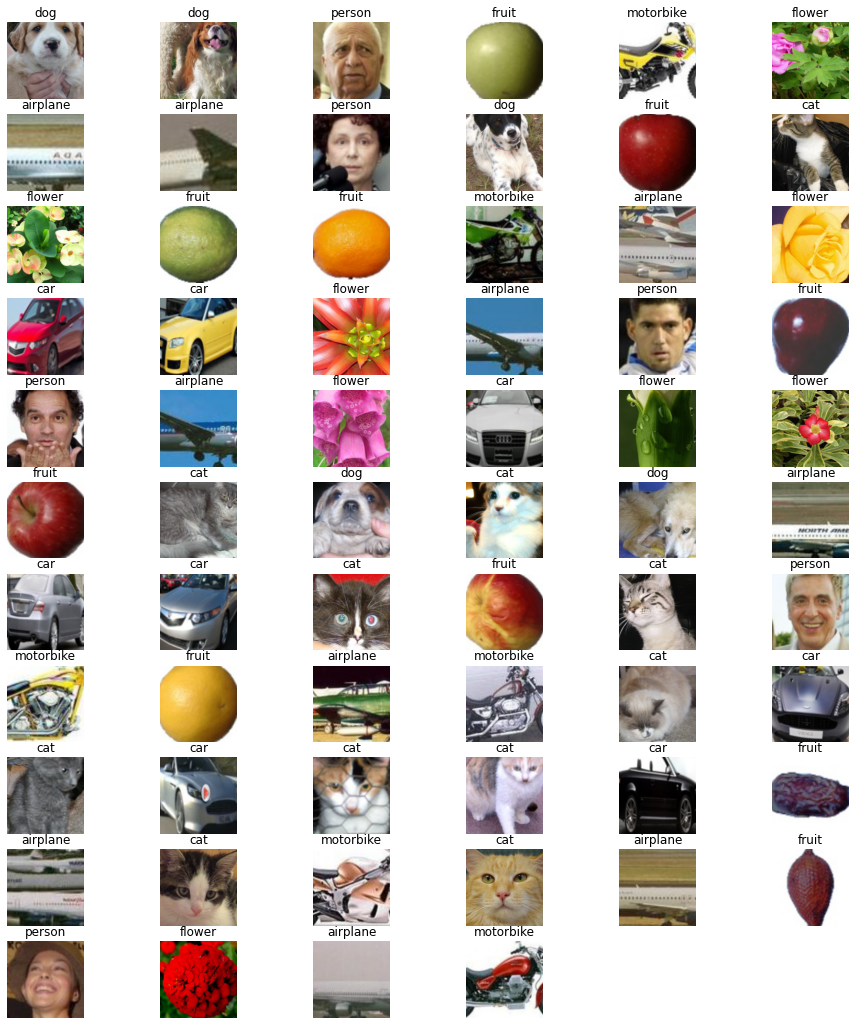

In [ ]:
# test for a few
import math
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)
rows, cols = 12, images.shape[0] // 10
plt.figure(figsize=(16, 20))
with torch.no_grad():
  pred = model(images)
  for num, (out_label, actual) in enumerate(zip(pred, labels)):
    plt.subplot(rows, cols, num + 1)
    plt.title(label_names[labels[num].item()])
    plt.axis('off')
    plt.imshow(images[num].squeeze(0).permute(1, 2, 0).cpu().numpy())